Imports

In [1]:
# Install system dependencies and required libraries
!apt-get update -qq && apt-get install -y -qq espeak-ng
!pip install -q transformers torchaudio librosa phonemizer sentencepiece

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package libpcaudio0:amd64.
(Reading database ... 117540 files and directories currently installed.)
Preparing to unpack .../libpcaudio0_1.1-6build2_amd64.deb ...
Unpacking libpcaudio0:amd64 (1.1-6build2) ...
Selecting previously unselected package libsonic0:amd64.
Preparing to unpack .../libsonic0_0.2.0-11build1_amd64.deb ...
Unpacking libsonic0:amd64 (0.2.0-11build1) ...
Selecting previously unselected package espeak-ng-data:amd64.
Preparing to unpack .../espeak-ng-data_1.50+dfsg-10ubuntu0.1_amd64.deb ...
Unpacking espeak-ng-data:amd64 (1.50+dfsg-10ubuntu0.1) ...
Selecting previously unselected package libespeak-ng1:amd64.
Preparing to unpack .../libespeak-ng1_1.50+dfsg-10ubuntu0.1_amd64.deb ...
Unpacking libespeak-ng1:amd64 (1.50+dfsg-10ubuntu0.1) ...
Selecting previ

1. Load a speech signal from the LJ Speech dataset.

In [22]:
import torch
import torchaudio
from IPython.display import Audio, display

speech_array, sampling_rate = torchaudio.load("LJ025-0076.wav")
print(f"Loaded audio with shape: {speech_array.shape} at {sampling_rate}Hz")

display(Audio(data=speech_array[0].numpy(), rate=sampling_rate))

Loaded audio with shape: torch.Size([1, 185146]) at 22050Hz


2. Preprocess the audio (convert to mono, resample to 16kHz)

In [3]:
# Convert to mono if it has more than one channel
if speech_array.shape[0] > 1:
    speech_array = torch.mean(speech_array, dim=0, keepdim=True)

# Resample to 16kHz
target_sr = 16000
if sampling_rate != target_sr:
    resampler = torchaudio.transforms.Resample(sampling_rate, target_sr)
    speech_array = resampler(speech_array)

# Standardize to 1D numpy array
input_audio = speech_array.squeeze().numpy()
print(f"Preprocessed audio shape: {input_audio.shape}")

Preprocessed audio shape: (134347,)


3. Use a pre-trained deep learning model (Wav2Vec2) to recognize phonemes

In [4]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

# Load model and processor
model_id = "facebook/wav2vec2-lv-60-espeak-cv-ft"
processor = Wav2Vec2Processor.from_pretrained(model_id)
model = Wav2Vec2ForCTC.from_pretrained(model_id)

# Process audio and get logits
inputs = processor(input_audio, sampling_rate=target_sr, return_tensors="pt", padding=True)
with torch.no_grad():
    logits = model(inputs.input_values).logits

# Decode the output
predicted_ids = torch.argmax(logits, dim=-1)
transcription = processor.batch_decode(predicted_ids)[0]
print(f"1. Recognized Phonemes: {transcription}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/424 [00:00<?, ?it/s]

1. Recognized Phonemes: m ɛ n i æ n ɪ m əl z ʌ v iː v ə n k ʌ m p l ɛ k s s t ɹ ʌ k tʃ ɚ w ɪ tʃ l ɪ v p æ ɹ ɪ s ɪ ɾ ɪ k l i w ɪ ð ɪ n ʌ ð ɚ z ɑːɹ h oʊ l i d ᵻ v oɪ d ʌ v ɐ n ɛ l ə m ɛ n t ɚ ɹ i k æ v ᵻ ɾ i


4. Estimate phoneme time intervals

In [5]:
# Get time per frame
num_frames = logits.shape[1]
duration = len(input_audio) / target_sr
time_per_frame = duration / num_frames

# Extract phonemes and their start times (removing duplicates and pads)
# Note: This is a simplified alignment; CTC decoding is greedy here
tokens = predicted_ids[0].numpy()
intervals = []

for i, token in enumerate(tokens):
    if token != processor.tokenizer.pad_token_id:
        phoneme = processor.decode([token])
        if phoneme.strip():  # ignore empty/white spaces
            start_time = i * time_per_frame
            intervals.append({"phoneme": phoneme, "start": start_time})

print(f"Extracted {len(intervals)} phoneme intervals.")
print("intervals : ",intervals)

Extracted 99 phoneme intervals.
intervals :  [{'phoneme': 'm', 'start': 0.0400796539379475}, {'phoneme': 'ɛ', 'start': 0.080159307875895}, {'phoneme': 'n', 'start': 0.18035844272076373}, {'phoneme': 'i', 'start': 0.22043809665871122}, {'phoneme': 'æ', 'start': 0.40079653937947496}, {'phoneme': 'n', 'start': 0.5210355011933174}, {'phoneme': 'ɪ', 'start': 0.5410753281622912}, {'phoneme': 'm', 'start': 0.6212346360381862}, {'phoneme': 'əl', 'start': 0.6613142899761337}, {'phoneme': 'z', 'start': 0.8617125596658712}, {'phoneme': 'ʌ', 'start': 1.0821506563245824}, {'phoneme': 'v', 'start': 1.1623099642004775}, {'phoneme': 'v', 'start': 1.1823497911694512}, {'phoneme': 'iː', 'start': 1.3226285799522675}, {'phoneme': 'v', 'start': 1.4228277147971362}, {'phoneme': 'ə', 'start': 1.4629073687350838}, {'phoneme': 'n', 'start': 1.523026849642005}, {'phoneme': 'k', 'start': 1.6031861575178998}, {'phoneme': 'ʌ', 'start': 1.683345465393795}, {'phoneme': 'm', 'start': 1.7234251193317425}, {'phoneme': 

5. Extract a phoneme segment from the speech signal

In [20]:
# Define your mapping to include the text label, voicing status, and phoneme type.
phoneme_map = {
    "ʃ": {"label": "sh", "voicing": "unvoiced", "type": "fricative"},
    "ʧ": {"label": "ch", "voicing": "unvoiced", "type": "affricate"},
    "θ": {"label": "th", "voicing": "unvoiced", "type": "fricative"},
    "ð": {"label": "dh", "voicing": "voiced", "type": "fricative"},
    "ŋ": {"label": "ng", "voicing": "voiced", "type": "nasal"},
    "s": {"label": "s", "voicing": "unvoiced", "type": "fricative"},
    "z": {"label": "z", "voicing": "voiced", "type": "fricative"},
    "f": {"label": "f", "voicing": "unvoiced", "type": "fricative"},
    "v": {"label": "v", "voicing": "voiced", "type": "fricative"},
    "p": {"label": "p", "voicing": "unvoiced", "type": "plosive"},
    "b": {"label": "b", "voicing": "voiced", "type": "plosive"},
    "t": {"label": "t", "voicing": "unvoiced", "type": "plosive"},
    "d": {"label": "d", "voicing": "voiced", "type": "plosive"},
    "k": {"label": "k", "voicing": "unvoiced", "type": "plosive"},
    "g": {"label": "g", "voicing": "voiced", "type": "plosive"},
    # Vowels
    "ɪ": {"label": "i", "voicing": "voiced", "type": "vowel"},
    "æ": {"label": "ae", "voicing": "voiced", "type": "vowel"},
    "ʊ": {"label": "u", "voicing": "voiced", "type": "vowel"},
    "ʌ": {"label": "uh", "voicing": "voiced", "type": "vowel"},
    "ə": {"label": "uh", "voicing": "voiced", "type": "vowel"},
    "ɛ": {"label": "eh", "voicing": "voiced", "type": "vowel"},
    "ɔ": {"label": "aw", "voicing": "voiced", "type": "vowel"},
    "ɑ": {"label": "ah", "voicing": "voiced", "type": "vowel"}
}

# Create a list to hold all the extracted segments for the next cell
extracted_phonemes = []

# Counters to keep track of how many we have extracted
voiced_count = 0
unvoiced_count = 0

# Loop through all intervals
for idx, target_p in enumerate(intervals):

    # If we already have 3 of both, we can break out of the loop completely
    if voiced_count >= 3 and unvoiced_count >= 3:
        break

    original_phoneme = target_p['phoneme']

    # Check the dictionary. Default to "unknown" if not found.
    mapping = phoneme_map.get(original_phoneme, {"label": original_phoneme, "voicing": "unknown", "type": "unknown"})
    p_label = mapping["label"]
    p_voicing = mapping["voicing"]
    p_type = mapping["type"] # Extract the phoneme type here

    # 1. Skip if it is an unknown phoneme
    if p_voicing == "unknown":
        continue

    # 2. Skip if we already have 3 voiced phonemes and this is a voiced one
    if p_voicing == "voiced" and voiced_count >= 3:
        continue

    # 3. Skip if we already have 3 unvoiced phonemes and this is an unvoiced one
    if p_voicing == "unvoiced" and unvoiced_count >= 3:
        continue

    p_start = target_p['start']

    # Define end time (either next phoneme start or end of audio)
    p_end = intervals[idx+1]['start'] if idx+1 < len(intervals) else duration

    # Convert time to sample indices
    start_samp = int(p_start * target_sr)
    end_samp = int(p_end * target_sr)

    # Skip if the segment is empty
    if start_samp >= end_samp:
        continue

    # Slice the audio array
    phoneme_segment = input_audio[start_samp:end_samp]

    # Store the results in our list, including the type
    extracted_phonemes.append({
        "index": idx,
        "label": p_label,
        "voicing": p_voicing,
        "type": p_type,
        "start": p_start,
        "end": p_end,
        "audio": phoneme_segment
    })

    # Update our counters
    if p_voicing == "voiced":
        voiced_count += 1
    elif p_voicing == "unvoiced":
        unvoiced_count += 1

    print(f"[{idx}] Extracted /{p_label}/ ({p_voicing} {p_type}) from {p_start:.2f}s to {p_end:.2f}s")

[1] Extracted /eh/ (voiced vowel) from 0.08s to 0.18s
[4] Extracted /ae/ (voiced vowel) from 0.40s to 0.52s
[6] Extracted /i/ (voiced vowel) from 0.54s to 0.62s
[17] Extracted /k/ (unvoiced plosive) from 1.60s to 1.68s
[21] Extracted /p/ (unvoiced plosive) from 1.80s to 1.88s
[24] Extracted /k/ (unvoiced plosive) from 2.04s to 2.06s


6. Save and Visualize the phoneme waveform

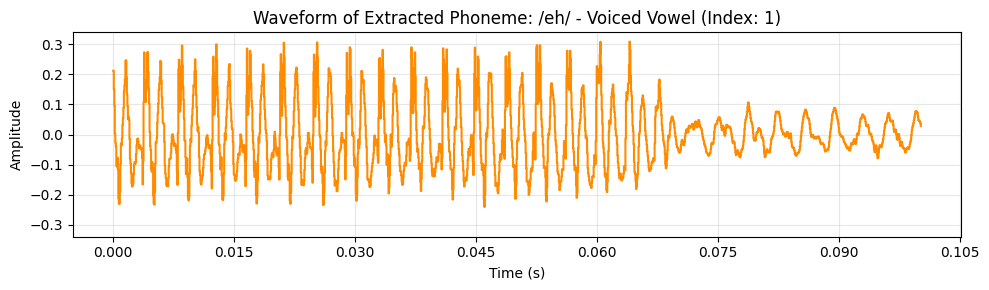

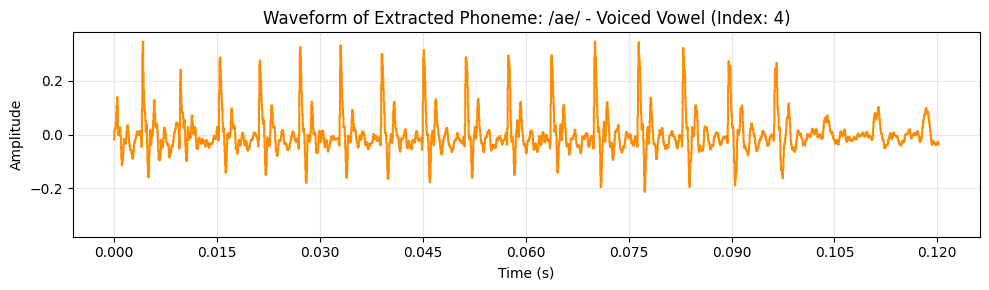

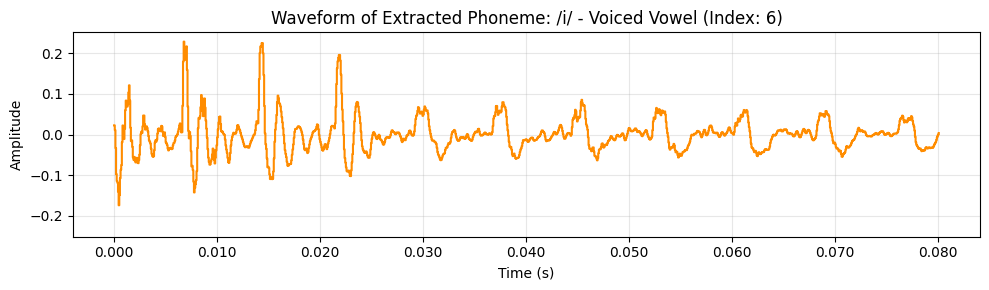

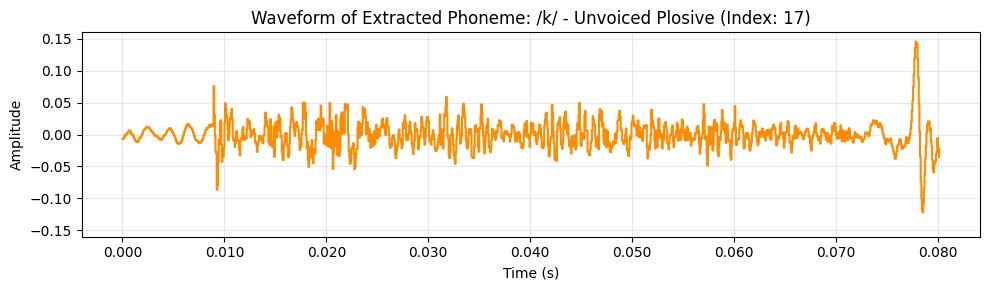

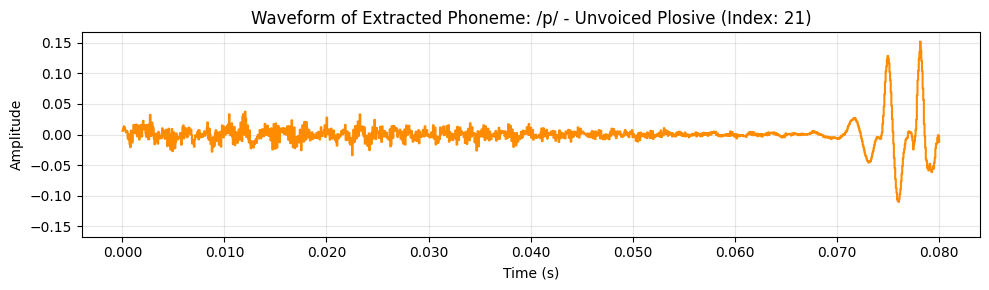

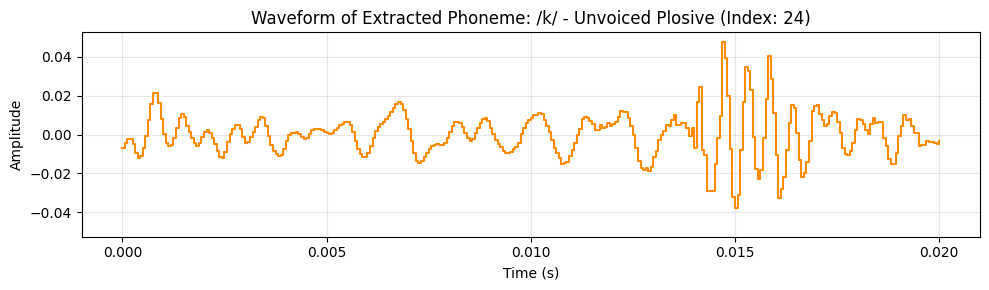

In [21]:
import os
import matplotlib.pyplot as plt
import librosa.display
import scipy.io.wavfile as wav

# Create a directory to keep your extracted audio files organized
output_dir = "all_phonemes"
os.makedirs(output_dir, exist_ok=True)

# Loop through the list we created in Cell 5
for item in extracted_phonemes:
    idx = item["index"]
    p_label = item["label"]
    p_voicing = item["voicing"]
    p_type = item["type"] # Extract type from the list
    phoneme_segment = item["audio"]

    # Clean the phoneme string for safe file naming
    safe_label = "".join([c if c.isalnum() else "_" for c in p_label])

    # Include voicing and type in the filename
    file_name = f"{output_dir}/{idx:03d}_{safe_label}_{p_voicing}_{p_type}.wav"

    # Save the extracted segment
    wav.write(file_name, target_sr, phoneme_segment)

    # Visualize
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(phoneme_segment, sr=target_sr, color="darkorange")

    # Added voicing AND type to the plot title
    title_str = f"Waveform of Extracted Phoneme: /{p_label}/ - {p_voicing.capitalize()} {p_type.capitalize()} (Index: {idx})"
    plt.title(title_str)

    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()